In [1]:
from docx2python import docx2python
import numpy as np
import os
import json
import pandas as pd
import pickle
import time
import tensorflow as tf
import matplotlib.pyplot as plt

#df, data frame of "sweunions.json"
#em, pre-trained embedding dictionary, 2,000,000 * 300

#### Get a graphics card (Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/TM'

In [ ]:
ls

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Trade Unions (2010-2020, förbundspress):
    * A, LO centralt
    * HR, Hotell- o resturangfacket;
    * H, Handelsanställdas förbund
    * L, Livsmedelsarbetarförbundet
    * K, Kommunalarbetarförbundet
    * DA,IF Metall
    * FF,Fastighetsansälldas förbund
    * BA,Byggnadsarbetarförbundet
    * E, Elektrikerförbundet
    * M, Målarna
    * S, Seko
    * T, Transportarbetarförbundet

### 1. Data Preparation

#### Load Session/States

In [2]:
#vocab0= pickle.load( open( "./States/code0_vocab.p", "rb" ) ) ## load vocab from code_0   NOOOOOOOOOOOOOO!!!!!!!!!!!!
#vocab1= pickle.load( open( "./States/code1_vocab1.p", "rb" ) ) ## load vocab from code_1  
#vocab= pickle.load( open( "./States/code1_vocab.p", "rb" ) ) ## load vocab from code_1, including 'unk' NOOOOOOOOOOOOOO!!!!!!!!!!!!
vocab_df1=pickle.load(open( "./States/code1_vocab_df1.p", "rb" ) ) ## load state for local words in df1 12633 words, exclusive 'unk'
vocab_common=pickle.load(open( "./States/code1_vocab_common.p", "rb" ) ) ## save state common vocab_df1+lemmatized words in em.keys(),   
                                                                        ## 10939, exclusive 'unk'

#em= pickle.load( open( "./States/code1_em.p", "rb" ) ) ## load pre-trained embeddings
em_common= pickle.load( open( "./States/code1_em_common.p", "rb" ) ) ## load common embeddings 10939
em_weights0=pickle.load(open( "./States/code1_em_weights0.p", "rb" ) ) ## save state for initial embeddings with pretrained vectors

#tags= pickle.load( open( "./States/code1_tags.p", "rb" ) ) ## load unique tags of docs
tags1= pickle.load( open( "./States/code1_tags1.p", "rb" ) ) ## load unique tags of sentences 16

[Xtrain,Ytrain]=pickle.load(open( "./States/code1_train.p", "rb" ) ) ## save state for training data
[Xval,Yval]=pickle.load(open( "./States/code1_valid.p", "rb" ) ) ## save state for valid data
[Xtest,Ytest]=pickle.load(open( "./States/code1_test.p", "rb" ) ) ## save state for test data
[X,Y]=pickle.load(open( "./States/code1_all.p", "rb" ) ) ## save state for valid data

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
vocab1=em.keys()  ## vocab from pretained embeddings
#pickle.dump(vocab1, open( "./States/code1_vocab1.p", "wb" ) ) ## save state for vocab1
vocab=[e for e in vocab0 if e in vocab1]  ## common words between pretrained embeddings and data of "press", excluding "unk"
vocab.append('unk') ## common words inclusive 'unk'
pickle.dump(vocab, open( "./States/code1_vocab.p", "wb" ) ) ## save state for vocab1
vocab1=list(vocab1)
pickle.dump(vocab1, open( "./States/code1_vocab1.p", "wb" ) ) ## save state for common vocab

In [3]:
#len(vocab_df1)
'unk' in vocab_common

False

#### Read press conference documents

In [4]:
with open('sweunions.json','r',encoding='utf-8') as source: #C:/Users/A550240/Desktop/LIU/3.2_TextMining/Project/1.SelectedData/
    df = pd.read_json(source) ## whole document
with open('sweunions_sentences.json','r',encoding='utf-8') as source: #C:/Users/A550240/Desktop/LIU/3.2_TextMining/Project/1.SelectedData/
    df1 = pd.read_json(source) ## each sentence

In [5]:
df.shape  ## shape of 482*4

(483, 4)

In [6]:
df1.head() ## 15395*4

,union,year,title,sentence
0,LO centralt,2010,Arbetare utnyttjas,Arbetare utnyttjas grovt Arbetare utnyttjas g...
1,LO centralt,2010,Arbetare utnyttjas,Den bedömningen gör professor Gregor Noll på ...
2,LO centralt,2010,Arbetare utnyttjas,Han ser två tunga orsaker till att papperslös...
3,LO centralt,2010,Arbetare utnyttjas,– Det ena är att vi allt mer konkurrerar med ...
4,LO centralt,2010,Arbetare utnyttjas,"Det andra skälet är, enligt Gregor Noll, att ..."


#### Tokenizer and POSer

In [7]:
import stanza

#stanza.download('sv')

In [8]:
nlp=stanza.Pipeline(lang='sv',processors='tokenize,lemma,pos')

2021-01-14 22:52:52 INFO: Loading these models for language: sv (Swedish):
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |
| lemma     | talbanken |

2021-01-14 22:52:52 INFO: Use device: cpu
2021-01-14 22:52:52 INFO: Loading: tokenize
2021-01-14 22:52:52 INFO: Loading: pos
2021-01-14 22:52:53 INFO: Loading: lemma
2021-01-14 22:52:53 INFO: Done loading processors!


In [9]:
## Tokenizer
def preprocess(doc):
    tok=nlp(doc)
    re1=[]
    re2=[]
    stop=['.',':',',','i','att','med','på','en','ett','till','och','-','–','den',
          'vara','av','som','men','till','denna','för','in','(',')','eller',
          'sån','sedan','•','?','om','!','%','&','--','\'','*','**','"','”','“','[avläsT',
          '[',']','/','»','«',';','=','+',
          '[accessed','[aläst','[avläst','[online]','[sg_popup','[ur', '[vläst',
          '‚ä®sverige', '…','‰r','″', '→', '●', '\uf0b7']
    za1=['"','(',')','“','”','*',':',',','.']
    for sentence in tok.sentences:
        for word in sentence.words:
            #print(word.lemma)
            if word.text in stop or word.text.isnumeric(): ## remove stop words and numbers
                pass            
            elif len(set(list('0123456789')).intersection(set(list(word.text))))>0: 
                pass            
            elif word.text not in za1 and len(set(za1).intersection(set(list(word.text))))>0:
                tem=str(word.text)
                for za in za1:
                    if tem.__contains__(za):
                        #print(tem)
                        ha=list(tem)
                        ha.remove(za)
                        tem=''.join(ha)
                #print(tem)
                if len(tem)>0:
                    f=[e.words for e in nlp(tem).sentences]
                    if len(f)>0:
                        re1.append(f[0][0].lemma)
                        re2.append(f[0][0].pos)
            elif word.text.endswith('-') or word.text.startswith('-') and word.text!='-' and word.text!='--':
                #print(word.text)
                mu=word.text.replace('-','')
                if len(mu)>0:  ## modified when building em_common_sum
                    f=[e.words for e in nlp(mu).sentences]     
                    re1.append(f[0][0].lemma)
                    re2.append(f[0][0].pos)
            else:
                re1.append(word.lemma)
                re2.append(word.pos)

        
    return re1,re2

def tokenizer(doc):
    re,_=preprocess(doc)
    return re

def pos(doc):
    _,re=preprocess(doc)
    return re

## tokenizer('jag var ingejörer')
## ['jag', 'vara', 'ingejör']
## tokenizer(df['press'][6])

#t=tokenizer(df['press'][368])  ## tokenizer
#p=pos(df['press'][368])  ## get POS 

In [10]:
tokenizer(df1['sentence'][6])

['denna',
 'eftersom',
 'vissa',
 'stanna',
 'kvar',
 'efter',
 'arbetstillstånd',
 'löpa',
 'ut']

#### Load pre-trained word embeddings (saved state)

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
import gzip

em={}
with gzip.open('cc.sv.300.vec.gz','rt',encoding="utf8") as source: ## 2,000,000 tokens
    header=True
    for line in source:
        if header==False:
            ro=line.split()
            #print(ro)
            em[ro[0]]=[float(f) for f in ro[1:]]
        header=False
## em no header, 2,000,000 * 300

pickle.dump(em, open( "./States/code1_em.p", "wb" ) ) ## save state for embeddings

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
vocab_df1=[]  ## build a word list for tokenized press sentences
for i in range(15395):
    t=tokenizer(df1.iloc[i]['sentence'])
    if t not in vocab_df1:
        vocab_df1.append(t)
vocab_df1=set([e for li in vocab_df1 for e in li])  ## 12633 words
pickle.dump(vocab_df1, open( "./States/code1_vocab_df1.p", "wb" ) ) ## save state for local words in df1 12633 words
##vocab_common=[e for e in vocab_df1 if e in vocab1]  ## common words between df1 and vocab1 10372 words
##vocab_common.append('unk')
##pickle.dump(vocab_common, open( "./States/code1_vocab_common.p", "wb" ) ) ## save state 

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
tik=time.clock()
cou=0
em_common_sum={} ## sum for words in pretrained embeddings which has the lemma included in common vocab
for k,v in em.items():
    #tok=tokenizer(str(k))
    try:
        tok=tokenizer(str(k))
        print(cou,':',str(k),tok)
        if tok[0] in vocab_common:
            print('HAHA')
            if tok[0] not in em_common_sum.keys():
                em_common_sum[tok]=[v,1]
            else:
                em_common_sum[tok][0]+=v
                em_common_sum[tok][1]+=1
    except:
        pass
    cou+=1
tok=time.clock()
print((tok-tik)/60)

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
#### bug when summing embeddings, for ex, em_common_sum['vara'][1]=426, len(em_common_sum['vara'][0])=127800
em_common_sum_real={}
for k,v in em_common_sum.items():
    if len(v[0])!=300*v[1]:
        print('NO',k)
    else:
        vec=np.array(v[0])
        mat=vec.reshape((v[1],300))
        su=np.sum(mat,0)
        em_common_sum_real.update({k:[su,v[1]]})

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
pickle.dump(em_common_sum_real, open( "./States/code1_em_common_sum_real.p", "wb" ) ) ## save state for embeddings
em_common={} ## average for words in pretrained embeddings which has the lemma included in common vocab
for key,val in em_common_sum_real.items():
    em_common[key]=[ e/val[1]  for e in val[0]]

pickle.dump(em_common, open( "./States/code1_em_common.p", "wb" ) ) ## save state for embeddings
em_common= pickle.load( open( "./States/code1_em_common.p", "rb" ) ) ## load common embeddings

#### Divide train-validate-test data

In [11]:
import random
random.seed(1234)
train_id=random.sample(range(15395),int(15395*0.7))
valid_id=random.sample([e for e in range(15395) if e not in train_id],int(15395*0.15))
test_id=[e for e in range(15395) if e not in train_id and e not in valid_id]

train=df1.iloc[train_id]
valid=df1.iloc[valid_id]
test=df1.iloc[test_id]

####  convert words and tags to unique integer index

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
# Convert all words and tags in train_data to lists, start with empty lists and use '.append()' 
# to add one word / tag at a time

tags = [] ## unique tags for press documents, 15 tags
tags1=[]  ## unique tags for sentences
## summarize tags in df
cou=0
for doc in df1['sentence']:
    print(cou)
    cou+=1
    if len(doc)>0:
        p=pos(doc)  ## tags for each document in given dataframe
        for tag in p:
            if tag not in tags1:
                tags1.append(tag)
pickle.dump(tags1, open( "./States/code1_tags1.p", "wb" ) ) ## save state for tags

In [12]:
words=list(vocab_df1)
words.append('unk')

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
def maxlen(dataset):  ### find the max length  of sentences in given dataset
    re=0
    for sen in dataset:
        tok=tokenizer(sen)
        if len(tok)>re:
            re=len(tok)
    return re
maxlen=maxlen(df1['sentence'])  ## maxlen = 74

In [13]:
num_tags=len(tags1)  ## number of unique tags

In [14]:
# Define a help function to build index from a list of words or tags, each word / tag will have a unique number
def build_index(strings, init=[]):
    string_to_index = {s: i for i, s in enumerate(init)}
    # Loop over strings in 'strings'
    for string in strings: 
        # Check if string exists in variable 'string_to_index', 
        # if string does not exist, add a new element to 'string_to_index': the current length of 'string_to_index'
        if string not in string_to_index.keys():
            string_to_index[string]=len(string_to_index)

    return string_to_index
        

# Call the help function you made, to build an index for words (word_to_index), and one index for tags (tag_to_index)
word_to_index=build_index(words)
tag_to_index=build_index(tags1)

# Check number of words and tags
num_words = len(word_to_index)
num_tags = len(tag_to_index)

print(f'Number of unique words in df: {num_words} (including <unk>)')
print(f'Number of unique tags in df: {num_tags}')

Number of unique words in df: 12634 (including <unk>)
Number of unique tags in df: 16


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# Make a function that converts the tagged sentences, word indices and tag indices to 
# X and Y, that can be used when training the RNN
def encode(dataset, word_to_index, tag_to_index):
    
    # Start with empty lists that will contain all training examples and corresponding output
    X, Y = [], []
    cou=0
    l=dataset.shape[0]
    
    # Loop over tagged sentences
    for doc in dataset:
        if cou%100==0:
            print(cou,'/',l)
        
        t=tokenizer(doc)  ## tokens of doc
        p=pos(doc)  ## targets of tokens in doc
        
        # Make empty lists for current sentence
        Xcurrent, Ycurrent = [], []
    
        # Loop over words and tags in current sentence
        for word,tag in zip(t,p):
             # Append the index for the current word to Xcurrent, 
             # if the word does not exist in 'word_to_index', add the index for '<unk>' instead
            if word in word_to_index.keys():
                Xcurrent.append(word_to_index[word])
            else:
                Xcurrent.append(word_to_index['unk'])

             # Append the index for the current tag to Ycurrent
            Ycurrent.append(tag_to_index[tag])    
        # Append X with Xcurrent, and Y with Ycurrent
        X.append(Xcurrent)
        Y.append(Ycurrent)
        cou+=1
    # Pad the sequences, so that all have the same length
    X=pad_sequences(X,maxlen=74)
    Y=pad_sequences(Y,maxlen=74)
    
    # Convert labels to categorical, as you did in the CNN lab
    Y=to_categorical(Y,num_tags+1)

    return X, Y
    
    

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
# Use your 'encode' function to create X and Y from train_data, word_to_index, tag_to_index
X,Y=encode(train['sentence'], word_to_index, tag_to_index)

pickle.dump([X,Y], open( "./States/code1_train.p", "wb" ) ) ## save state for training dataset

In [16]:
# Print the shape of X and Y
print('Shape of Xtrain: {}'.format(Xtrain.shape)) 
print('Shape of Ytrain: {}'.format(Ytrain.shape))    



Shape of Xtrain: (10776, 74)
Shape of Ytrain: (10776, 74, 17)


### 4. Model selection 

#### Construct model

In [17]:
from tensorflow.keras import Sequential
# Import necessary layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed, RepeatVector
from keras.losses import categorical_crossentropy as cc
from keras.optimizers import Adam

embedding_dim = 300
hidden_dim = 300
#learning_rate=0.01
input_length=X.shape[1]

# Create model, similar to how it was done in the DNN and CNN labs
model = Sequential()

# The model should have an embedding layer, a bidirectional LSTM, and a dense softmax layer 
# (see the network architecture image)

model.add(Embedding(num_words, embedding_dim, input_length=input_length, weights=[em_weights0], trainable=True))
model.add(Bidirectional(LSTM(hidden_dim,return_sequences=True)))
#model.add(RepeatVector(input_length))
model.add(TimeDistributed(Dense(num_tags+1, activation='softmax')))

Using TensorFlow backend.


In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
em_weights=model.layers[0].get_weights()[0]  ## shape (12634, 300)
em_weights0=em_weights
for i,v in enumerate(words):
    if v in vocab_common:
        em_weights0[i]=em_common[v]
pickle.dump(em_weights0, open( "./States/code1_em_weights0.p", "wb" ) ) ## save state for initial embeddings with pretrained vectors

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
#words.index('vara')  ## index 192
ouem=model.layers[0](X)
sum([e[0]-e[1] for e in zip(ouem[10][70].numpy(),em_common[words[X[10][70]]])])  ## check if em_weights0 has the correct settings so that 
                                                       ## right dimensions corresponds right word

In [18]:
# Compile model
model.compile('adam', cc, metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 74, 300)           3790200   
_________________________________________________________________
bidirectional (Bidirectional (None, 74, 600)           1442400   
_________________________________________________________________
time_distributed (TimeDistri (None, 74, 17)            10217     
Total params: 5,242,817
Trainable params: 5,242,817
Non-trainable params: 0
_________________________________________________________________


#### Train

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
# Encode the development (validation data) using the 'encode' function you created before
Xval,Yval=encode(valid['sentence'], word_to_index, tag_to_index)
pickle.dump([Xval,Yval], open( "./States/code1_valid.p", "wb" ) ) ## save state for valid dataset


In [19]:
## Train 
# Train the model and save the history, provide validation data
batch_size = 32
epochs = 10
history = model.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(Xval,Yval))

Train on 10776 samples, validate on 2309 samples
Epoch 1/10
10776/10776 - 259s - loss: 0.2062 - accuracy: 0.9435 - val_loss: 0.0328 - val_accuracy: 0.9903
Epoch 2/10
10776/10776 - 251s - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0234 - val_accuracy: 0.9926
Epoch 3/10
10776/10776 - 258s - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0229 - val_accuracy: 0.9926
Epoch 4/10
10776/10776 - 257s - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.0231 - val_accuracy: 0.9928
Epoch 5/10
10776/10776 - 211s - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.0251 - val_accuracy: 0.9923
Epoch 6/10
10776/10776 - 157s - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0259 - val_accuracy: 0.9927
Epoch 7/10
10776/10776 - 158s - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0278 - val_accuracy: 0.9922
Epoch 8/10
10776/10776 - 158s - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0286 - val_accuracy: 0.9922
Epoch 9/10
10776/10776 - 157s - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.0338 - val_accuracy: 0.99

#### Validate

In [20]:
## validate
# Lets define a help function for plotting the training results


def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

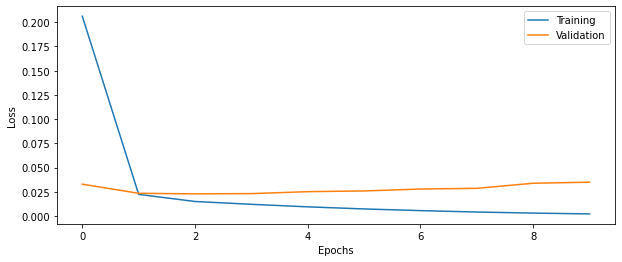

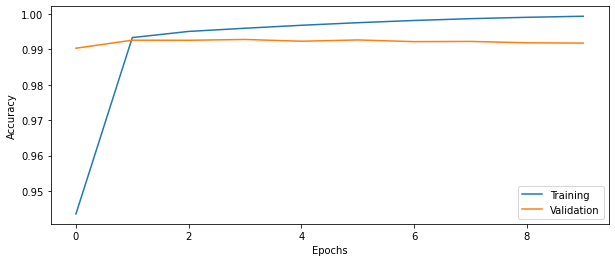

In [21]:
plot_results(history)  ##  Choose epochs=3

#### Evaluate

In [ ]:
##!!!!!! NO MORE RUN  !!!!!!!!!!!!
# Encode the test_data using the 'encode' function you created before
Xtest,Ytest=encode(test['sentence'], word_to_index, tag_to_index)
pickle.dump([Xtest,Ytest], open( "./States/code1_test.p", "wb" ) ) ## save state for test dataset


In [22]:
## evaluate on test data
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=input_length, weights=[em_weights0], trainable=True))
model.add(Bidirectional(LSTM(hidden_dim,return_sequences=True)))
model.add(TimeDistributed(Dense(num_tags+1, activation='softmax')))
model.compile('adam', cc, metrics=['accuracy'])

model.fit(Xtrain,Ytrain,batch_size=batch_size,epochs=3,verbose=2)

score = model.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Train on 10776 samples
Epoch 1/3
10776/10776 - 147s - loss: 0.2131 - accuracy: 0.9420
Epoch 2/3
10776/10776 - 144s - loss: 0.0228 - accuracy: 0.9931
Epoch 3/3
10776/10776 - 144s - loss: 0.0151 - accuracy: 0.9950
2310/2310 [==============================] - 11s 5ms/sample - loss: 0.0232 - accuracy: 0.9925
Test loss: 0.0232
Test accuracy: 0.9925


### 5. Retrain with whole dataset / Update Embeddings

#### Train by years

In [23]:
[X,Y]=pickle.load(open( "./States/code1_all.p", "rb" ) )  ## load whole training dataset
def train(par,li): 
    embedding_dim = 300
    hidden_dim = 300
    input_length=74
    
    for ele in li:
        print(par,':',ele)
        
        ## construct model
        model = Sequential()
        # The model should have an embedding layer, a bidirectional LSTM, and a dense softmax layer 
        model.add(Embedding(num_words, embedding_dim, input_length=input_length, weights=[em_weights0], trainable=True))
        model.add(Bidirectional(LSTM(hidden_dim,return_sequences=True)))
        #model.add(RepeatVector(input_length))
        model.add(TimeDistributed(Dense(num_tags+1, activation='softmax')))
        # Compile model
        model.compile('adam', cc, metrics=['accuracy'])

        if par=='year':
            ind=(df1[par]==(ele-1)) | (df1[par]==ele)  |  (df1[par]==(ele+1))     ## filter index 
        if par=='union':
            ind=df1[par]==ele   ## filter index   
        
        x,y=X[ind],Y[ind]   ## extract dataset from "code1_all" which is already encoded and saved       
        model.fit(x,y,batch_size=batch_size,epochs=3,verbose=2)
        em_weights_trained=model.layers[0].get_weights()[0] 
        pickle.dump(em_weights_trained, open( ("./States/code1_em_weights_"+str(ele)+".p"), "wb" ) ) ## save weights   

In [24]:
years=[e+2011 for e in list(range(9))]   ### year 2011-2019
train('year',years)

year : 2011
Train on 1745 samples
Epoch 1/3
1745/1745 - 25s - loss: 0.5647 - accuracy: 0.8660
Epoch 2/3
1745/1745 - 23s - loss: 0.3296 - accuracy: 0.8919
Epoch 3/3
1745/1745 - 23s - loss: 0.2257 - accuracy: 0.9315
year : 2012
Train on 2374 samples
Epoch 1/3
2374/2374 - 33s - loss: 0.4989 - accuracy: 0.8717
Epoch 2/3
2374/2374 - 32s - loss: 0.2652 - accuracy: 0.9163
Epoch 3/3
2374/2374 - 32s - loss: 0.1069 - accuracy: 0.9731
year : 2013
Train on 2703 samples
Epoch 1/3
2703/2703 - 38s - loss: 0.4836 - accuracy: 0.8730
Epoch 2/3
2703/2703 - 37s - loss: 0.2466 - accuracy: 0.9238
Epoch 3/3
2703/2703 - 37s - loss: 0.0892 - accuracy: 0.9791
year : 2014
Train on 3748 samples
Epoch 1/3
3748/3748 - 52s - loss: 0.4198 - accuracy: 0.8855
Epoch 2/3
3748/3748 - 50s - loss: 0.1194 - accuracy: 0.9675
Epoch 3/3
3748/3748 - 50s - loss: 0.0299 - accuracy: 0.9921
year : 2015
Train on 4569 samples
Epoch 1/3
4569/4569 - 68s - loss: 0.3865 - accuracy: 0.8937
Epoch 2/3
4569/4569 - 67s - loss: 0.0851 - accurac

#### Train by unions

In [33]:
unions=list(set(list(df1['union'])))   ##  all unions
train('union',unions)

union : Målarna
Train on 362 samples
Epoch 1/3
362/362 - 7s - loss: 1.2883 - accuracy: 0.8019
Epoch 2/3
362/362 - 6s - loss: 0.4535 - accuracy: 0.8651
Epoch 3/3
362/362 - 6s - loss: 0.3983 - accuracy: 0.8790
union : Livsmedelsarbetarförbundet
Train on 1126 samples
Epoch 1/3
1126/1126 - 19s - loss: 0.6604 - accuracy: 0.8569
Epoch 2/3
1126/1126 - 18s - loss: 0.3546 - accuracy: 0.8822
Epoch 3/3
1126/1126 - 17s - loss: 0.3010 - accuracy: 0.9051
union : Kommunalarbetarförbundet
Train on 2097 samples
Epoch 1/3
2097/2097 - 35s - loss: 0.5410 - accuracy: 0.8642
Epoch 2/3
2097/2097 - 33s - loss: 0.3097 - accuracy: 0.9006
Epoch 3/3
2097/2097 - 33s - loss: 0.1602 - accuracy: 0.9569
union : Transportarbetarförbundet
Train on 1713 samples
Epoch 1/3
1713/1713 - 28s - loss: 0.5316 - accuracy: 0.8777
Epoch 2/3
1713/1713 - 26s - loss: 0.2985 - accuracy: 0.9008
Epoch 3/3
1713/1713 - 26s - loss: 0.2135 - accuracy: 0.9352
union : Fastighetsansälldas förbund
Train on 959 samples
Epoch 1/3
959/959 - 16s - l

### 6. Analysis

In [25]:
nwords=['arbetsmarknad','jobb','chans','tjänst','yrke',
        'arbetsförmedling','arbetstagare','lön','intervju','anställning']  ## neutral words 10
swords=['svensk','medborgare','inrikes','Tomas','Björn',
        'Lena','anna','Stefan','Karin','Sara',
        'Malin','Andreas','Jan','Johansson','Maria',
        'Erik','Sven','Peter','Carl','Mikael',
        'Elisabeth','Eva','Kristina','Birgitta']  ## svensk group 25
iwords=['invandrare','flykting','migration','visum',
        'asyl','utomlands','arbetstillstånd','migrationsverket','asylsökande',
        'arbetskraftsinvandring']  ## immigrants group 10

In [26]:
[e for e in iwords if e not in vocab_common]  ## make sure words from vocab_common

[]

In [27]:
'Lena' in vocab_common

True

In [28]:
def word2vec(weight,word):  ## convert word into vectors
    ind=words.index(word)
    vec=weight[ind]
    return vec

def dis(weight,vec,word):  ##  L2 norm distance between word a and b
    return np.sqrt(np.sum(np.square(vec-word2vec(weight,word))))

def avg(weight,group):  ## calculate average vectors for word groups
    re=np.array(np.zeros(300))
    for word in group:
        re+=word2vec(weight,word)
    return re/len(group)

def rnd(weight,nwords,swords,iwords):  ## relative norm distance
    svec=avg(weight,swords)
    ivec=avg(weight,iwords)
    re=0
    for word in nwords:
        re+=dis(weight,svec,word)-dis(weight,ivec,word) ##  dis(swords)-dis(iwords)
    return re/len(nwords)

#### By years

In [29]:
em_weights_2011=pickle.load(open( ("./States/code1_em_weights_2011.p"), "rb" ) )
em_weights_2012=pickle.load(open( ("./States/code1_em_weights_2012.p"), "rb" ) )
em_weights_2013=pickle.load(open( ("./States/code1_em_weights_2013.p"), "rb" ) )
em_weights_2014=pickle.load(open( ("./States/code1_em_weights_2014.p"), "rb" ) )
em_weights_2015=pickle.load(open( ("./States/code1_em_weights_2015.p"), "rb" ) )
em_weights_2016=pickle.load(open( ("./States/code1_em_weights_2016.p"), "rb" ) )
em_weights_2017=pickle.load(open( ("./States/code1_em_weights_2017.p"), "rb" ) )
em_weights_2018=pickle.load(open( ("./States/code1_em_weights_2018.p"), "rb" ) )
em_weights_2019=pickle.load(open( ("./States/code1_em_weights_2019.p"), "rb" ) )

In [30]:
years=[e+2011 for e in list(range(9))]  
rnd_years=[]
for i in years:
    rnd_years.append(rnd(eval('em_weights_'+str(i)),nwords,swords,iwords))

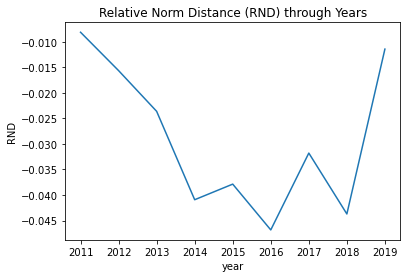

In [31]:
plt.title('Relative Norm Distance (RND) through Years')
plt.xlabel('year')
plt.ylabel('RND')
plt.plot(years,rnd_years);

In [32]:
rnd_years

[-0.008106756481424327,
 -0.015624323511668875,
 -0.023603638308422936,
 -0.04092741236309149,
 -0.03787092920182556,
 -0.046844558017092,
 -0.031785570642878846,
 -0.043719154750079266,
 -0.011410642172627305]

#### By unions

Trade Unions (2010-2020, förbundspress):
    * A, LO centralt
    * HR, Hotell- o resturangfacket;
    * H, Handelsanställdas förbund
    * L, Livsmedelsarbetarförbundet
    * K, Kommunalarbetarförbundet
    * DA,IF Metall
    * FF,Fastighetsansälldas förbund
    * BA,Byggnadsarbetarförbundet
    * E, Elektrikerförbundet
    * M, Målarna
    * S, Seko
    * T, Transportarbetarförbundet

In [34]:
em_weights_A=pickle.load(open( ("./States/code1_em_weights_LO centralt.p"), "rb" ) )
em_weights_S=pickle.load(open( ("./States/code1_em_weights_Seko.p"), "rb" ) )
em_weights_DA=pickle.load(open( ("./States/code1_em_weights_IF Metall.p"), "rb" ) )
em_weights_T=pickle.load(open( ("./States/code1_em_weights_Transportarbetarförbundet.p"), "rb" ) )
em_weights_FF=pickle.load(open( ("./States/code1_em_weights_Fastighetsansälldas förbund.p"), "rb" ) )
em_weights_HR=pickle.load(open( ("./States/code1_em_weights_Hotell- o resturangfacket.p"), "rb" ) )
em_weights_K=pickle.load(open( ("./States/code1_em_weights_Kommunalarbetarförbundet.p"), "rb" ) )
em_weights_L=pickle.load(open( ("./States/code1_em_weights_Livsmedelsarbetarförbundet.p"), "rb" ) )
em_weights_H=pickle.load(open( ("./States/code1_em_weights_Handelsanställdas förbund.p"), "rb" ) )
em_weights_BA=pickle.load(open( ("./States/code1_em_weights_Byggnadsarbetarförbundet.p"), "rb" ) )
em_weights_E=pickle.load(open( ("./States/code1_em_weights_Elektrikerförbundet.p"), "rb" ) )
em_weights_M=pickle.load(open( ("./States/code1_em_weights_Målarna.p"), "rb" ) )

In [35]:
unions=['A','S','DA','T','FF','HR','K','L','H','BA','E','M']
rnd_unions=[]
for i in unions:
    rnd_unions.append(rnd(eval('em_weights_'+str(i)),nwords,swords,iwords))

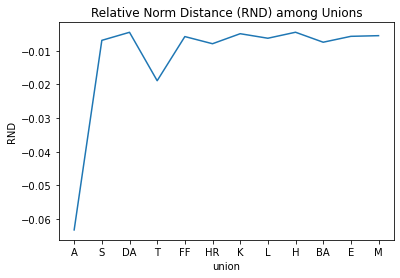

In [36]:
plt.title('Relative Norm Distance (RND) among Unions')
plt.xlabel('union')
plt.ylabel('RND')
plt.plot(unions,rnd_unions);

In [37]:
rnd_unions

[-0.06325732452628795,
 -0.006916952908607684,
 -0.0045262011947210775,
 -0.018914005090076146,
 -0.0057952592597989685,
 -0.007921799299650983,
 -0.004944836348501308,
 -0.006291385531424018,
 -0.004508894326484716,
 -0.007473745413192312,
 -0.005725089419912191,
 -0.005526497758183821]

### 7. Test 